In [283]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.svm import LinearSVR

# Data Loading

In [250]:
df = pd.read_csv('data/ecommerce_customer_data_cleaned.csv')
df = df.iloc[:, 2:]
df

,Age,Gender,IncomeLevel,Country,City,TotalPurchases,AverageOrderValue,CustomerLifetimeValue,EmailEngagementRate,SocialMediaEngagementRate,...,PremiumMember,HasReturnedItems,FavoriteCategory_Beauty,FavoriteCategory_Books,FavoriteCategory_Clothing,FavoriteCategory_Electronics,FavoriteCategory_Food,FavoriteCategory_Home Goods,FavoriteCategory_Sports,FavoriteCategory_Toys
0,25,Prefer not to say,High,Japan,Tokyo,4,15.886509,327.828625,0.332365,0.379694,...,Yes,No,0.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0
1,38,Prefer not to say,High,United Kingdom,London,6,27.638853,181.725056,0.344574,0.140988,...,No,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.5
2,43,Prefer not to say,High,France,Paris,10,161.739425,1810.555150,0.409656,0.323660,...,No,Yes,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
3,49,Female,High,United States,Los Angeles,5,14.194263,86.219740,0.356765,0.268428,...,Yes,No,0.0,0.0,0.5,0.0,0.0,0.0,1.0,0.0
4,29,Female,Very High,Japan,Tokyo,7,298.953396,2112.575945,0.222703,0.160427,...,No,No,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,39,Female,High,United States,New York,4,60.986389,212.992614,0.105934,0.128575,...,Yes,Yes,0.0,0.0,0.0,0.0,0.5,0.0,0.0,1.0
9996,58,Prefer not to say,Low,Australia,Sydney,6,75.208556,549.352094,0.424127,0.298521,...,No,Yes,0.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0
9997,38,Other,Very High,United States,New York,1,37.196899,117.203509,0.487704,0.126018,...,No,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9998,29,Other,High,Germany,Berlin,3,13.191952,-6.655247,0.377627,0.600112,...,No,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [251]:
predict_column = 'CustomerLifetimeValue'
feature_columns = list(df.columns)
feature_columns.remove(predict_column)

# Model Training

In [252]:
def clv_regression(X, y):
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in list(X.columns) if c not in num_cols]
    
    numeric_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components = 0.95))
    ])

    cat_pipeline = Pipeline([
            ('encoder', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False))
        ])

    # combine pipelines into single preprocessor
    transformers = [
        ('num', numeric_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ]

    preprocessor = ColumnTransformer(transformers, remainder = 'drop')
    
    param_grid = {
        "C": [0.01, 0.1, 1, 10, 100],
        "epsilon": [0.0001, 0.001, 0.01, 0.1, 1],
        "loss": ["epsilon_insensitive", "squared_epsilon_insensitive"],
        "dual": [True, False],
        "max_iter": [5000, 10000, 50000],
    }

    model = LinearSVR(C = 2.0, max_iter = 20000, epsilon = 0.0001)

    # data flow pipeline
    pipe = Pipeline([ 
        ('preprocess', preprocessor),
        ('regressor', model)
    ])

    # train the model
    pipe.fit(X, y)
    
    return pipe

In [253]:
X = df[feature_columns]
y = df[predict_column]

In [254]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [255]:
model = clv_regression(X_train, y_train)
model

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Inference

In [256]:
y_pred = model.predict(X_test)

In [257]:
y_pred

array([435.24051841, 655.66533689, 622.07052016, ..., 274.98542408,
        67.17912039, 241.19977973], shape=(3000,))

In [258]:
y_test

1013     296.053605
3334     849.303312
657      751.111999
7703      41.307880
1434    1237.828245
           ...     
6372     114.143454
267      459.705656
7321     166.126394
1428     135.753798
4778     381.461113
Name: CustomerLifetimeValue, Length: 3000, dtype: float64

# Evaluation

## MAE

In [259]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

MAE: 171.95399358248446


## Plot

In [280]:
sorted_indecies = y_test.argsort()
y_test_sorted = y_test.iloc[sorted_indecies.values]
y_pred_sorted_by_test = y_pred[sorted_indecies.values]

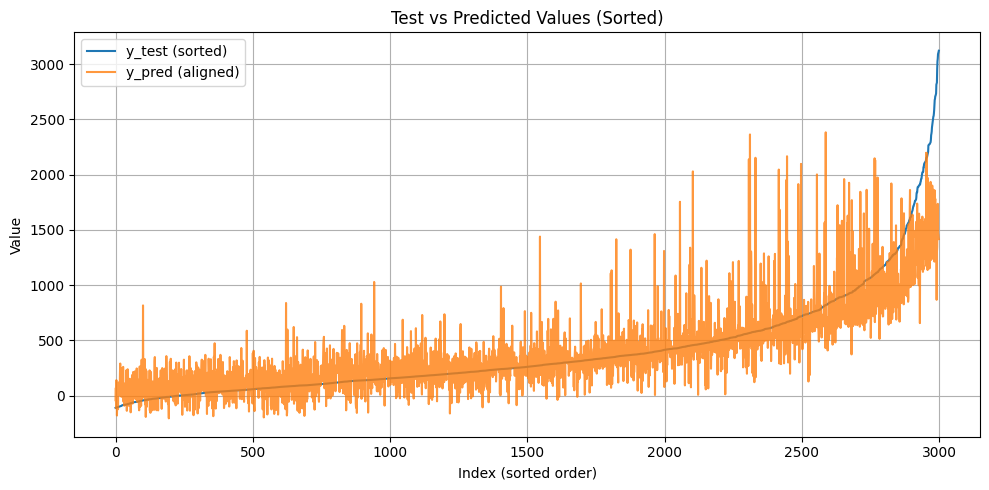

In [282]:
plt.figure(figsize=(10, 5))

plt.plot(y_test_sorted.values, label="y_test (sorted)")
plt.plot(y_pred_sorted_by_test, label="y_pred (aligned)", alpha=0.8)

plt.xlabel("Index (sorted order)")
plt.ylabel("Value")
plt.title("Test vs Predicted Values (Sorted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()